# Interactions - Lab

## Introduction

In this lab, you'll explore interactions in the Ames Housing dataset.

## Objectives

You will be able to:
- Implement interaction terms in Python using the `sklearn` and `statsmodels` packages 
- Interpret interaction variables in the context of a real-world problem 

## Build a baseline model 

You'll use a couple of built-in functions, which we imported for you below: 

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import statsmodels.api as sm

In [3]:
import warnings
warnings.filterwarnings('ignore')

If you still want to build a model in the end, you can do that, but this lab will just focus on finding meaningful insights in interactions and how they can improve $R^2$ values.

In [4]:
regression = LinearRegression()

Create a baseline model which includes all the variables we selected from the Ames housing data set to predict the house prices. Then use 10-fold cross-validation and report the mean $R^2$ value as the baseline $R^2$.

In [5]:
ames = pd.read_csv('ames.csv')

continuous = ['LotArea', '1stFlrSF', 'GrLivArea', 'SalePrice']
categoricals = ['BldgType', 'KitchenQual', 'SaleType', 'MSZoning', 'Street', 'Neighborhood']

In [6]:
# Create transformation functions for continuous predictors
def log_transform(cols, dt):
    dt_log = pd.DataFrame([])
    for c in cols:
        dt_log[f'log_{c}'] = np.log(dt[c])
        
    return dt_log

def standardize(cols, dt):
    dt_standard = pd.DataFrame([])
    for c in cols:
        dt_standard[f'standardized_{c}'] = (dt[c] - np.mean(dt[c])) / np.std(dt[c])
    return dt_standard

to_log = ['LotArea', 'GrLivArea', '1stFlrSF']
# apply log_transform on the 3 selected features 
log_ames_cont = log_transform(to_log, ames[continuous])

to_standardize = ['log_LotArea', 'log_GrLivArea', 'log_1stFlrSF']
# Apply standardize on log_ames_cont
final_cont = standardize(to_standardize, log_ames_cont)

In [7]:
# Apply OneHotEncoder() on categorical predictors
ohe = OneHotEncoder(drop='first')
ohe.fit(ames[categoricals])
ohe_trans = ohe.transform(ames[categoricals])

final_cat = pd.DataFrame(ohe_trans.todense(), columns=ohe.get_feature_names())

In [8]:
X = pd.concat([final_cont, final_cat], axis=1)
y = ames.SalePrice

In [9]:
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=19)
baseline = np.mean(cross_val_score(regression, X, y, scoring='r2', cv=crossvalidation))

baseline

0.7779580670320424

## See how interactions improve your baseline

Next, create all possible combinations of interactions, loop over them and add them to the baseline model one by one to see how they affect the $R^2$. We'll look at the 3 interactions which have the biggest effect on our $R^2$, so print out the top 3 combinations.

You will create a `for` loop to loop through all the combinations of 2 predictors. You can use `combinations` from itertools to create a list of all the pairwise combinations. To find more info on how this is done, have a look [here](https://docs.python.org/2/library/itertools.html).

Since there are so many different neighbourhoods we will exclude

In [10]:
from itertools import combinations

pairs = list(combinations(X.columns, 2))

r2_dct = {}
X_interact = X.copy()
for f1, f2 in pairs:
    X_interact['interaction'] = X[f1] * X[f2]
    score = np.mean(cross_val_score(regression, X_interact, y,
                                    scoring='r2',
                                    cv=crossvalidation))
    # only record r2 scores > baseline
    if score > baseline:
        r2_dct[f'{f1}-{f2}'] = score

In [11]:
# code to find top interactions by R^2 value here
sorted_r2 = sorted(r2_dct.items(), key=lambda i: i[1], reverse=True)
sorted_r2[:3]

[('standardized_log_GrLivArea-x5_NoRidge', 0.7937242630421302),
 ('standardized_log_1stFlrSF-x5_NoRidge', 0.786722010719708),
 ('standardized_log_GrLivArea-x1_TA', 0.7866504289391143)]

It looks like the top interactions involve the Neighborhood_Edwards feature so lets add the interaction between LotArea and Edwards to our model. 

We can interpret this feature as the relationship between LotArea and SalePrice when the house is in Edwards or not.

--------
[CB] I did not really get the same results as the solution; and it might be due to the following:
- The solution did not drop the first column when creating dummies

In accordance with my results, I would proceed to the next steps using the NoRidge neighborhood instead of Edwards.

And I would then interpret the relationship between `standardized_log_GrLivArea` (instead of `LotArea`) and `SalePrice`.

## Visualize the Interaction

Separate all houses that are located in Edwards and those that are not. Run a linear regression on each population against `SalePrice`. Visualize the regression line and data points with price on the y axis and LotArea on the x axis.

In [12]:
preprocessed = pd.concat([X, y], axis=1)
preprocessed.head()

,standardized_log_LotArea,standardized_log_GrLivArea,standardized_log_1stFlrSF,x0_2fmCon,x0_Duplex,x0_Twnhs,x0_TwnhsE,x1_Fa,x1_Gd,x1_TA,...,x5_NridgHt,x5_OldTown,x5_SWISU,x5_Sawyer,x5_SawyerW,x5_Somerst,x5_StoneBr,x5_Timber,x5_Veenker,SalePrice
0,-0.133231,0.529260,-0.803570,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,208500
1,0.113442,-0.381846,0.418585,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,181500
2,0.420061,0.659675,-0.576560,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,223500
3,0.103347,0.541511,-0.439287,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,140000
4,0.878409,1.282191,0.112267,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,250000


In [13]:
# Split preprocessed into 2 different datasets 
noridge = preprocessed[preprocessed.x5_NoRidge == 1]
not_noridge = preprocessed[~(preprocessed.x5_NoRidge == 1)]

# fit models & make predictions
reg_noridge = LinearRegression()
reg_not_noridge = LinearRegression()

grlivarea_1 = noridge.standardized_log_GrLivArea.values.reshape(-1,1)
grlivarea_2 = not_noridge.standardized_log_GrLivArea.values.reshape(-1,1)

reg_noridge.fit(grlivarea_1, noridge.SalePrice)
reg_not_noridge.fit(grlivarea_2, not_noridge.SalePrice)

pred_1 = reg_noridge.predict(grlivarea_1)
pred_2 = reg_not_noridge.predict(grlivarea_2)

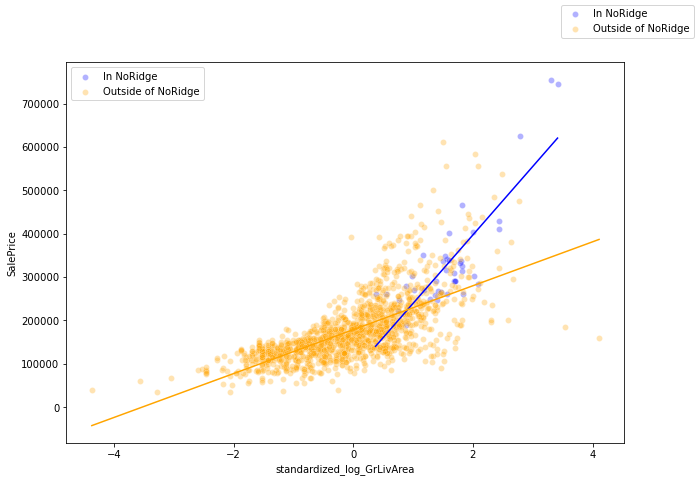

In [14]:
fig, ax = plt.subplots(figsize=(10,7))
# Scatter plots for actual data
sns.scatterplot(noridge.standardized_log_GrLivArea, noridge.SalePrice, 
                color='blue', alpha=0.3, label='In NoRidge', ax=ax)
sns.scatterplot(not_noridge.standardized_log_GrLivArea, not_noridge.SalePrice, 
                color='orange', alpha=0.3, label='Outside of NoRidge', ax=ax)

# Line plots for prediction
sns.lineplot(noridge.standardized_log_GrLivArea, pred_1,
             color='blue', ax=ax)
sns.lineplot(not_noridge.standardized_log_GrLivArea, pred_2,
             color='orange', ax=ax)

fig.legend();

## Build a final model with interactions

Use 10-fold cross-validation to build a model using the above interaction. 

In [15]:
regression = LinearRegression()
X_interact = X.copy()
X_interact['standardized_log_GrLivArea - x5_NoRidge'] = X.standardized_log_GrLivArea * X.x5_NoRidge

r2_interact = np.mean(cross_val_score(regression, X_interact, y,
                                      scoring='r2', cv=crossvalidation))
r2_interact

0.7937242630421302

Our $R^2$ has increased considerably! Let's have a look in `statsmodels` to see if this interactions are significant.

In [16]:
# code here
X_interact_sm = sm.add_constant(X_interact)
model = sm.OLS(y, X_interact_sm).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     139.8
Date:                Sun, 14 Feb 2021   Prob (F-statistic):               0.00
Time:                        17:38:35   Log-Likelihood:                -17266.
No. Observations:                1460   AIC:                         3.463e+04
Df Residuals:                    1411   BIC:                         3.489e+04
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                    2.392e+05   2.17e+04     11.004      0.000    1.97e+05    2.82e+05
standardized_log_LotArea                 1.052e+04   1556.891      6.757      0.000    7465.076    1.36e+04
standardized_log_GrLivArea               2.323e+04   1294.126     17.948      0.000    2.07e+04    2.58e+04
standardized_log_1stFlrSF                9964.1517   1319.463      7.552      0.000    7375.833    1.26e+04
x0_2fmCon                               -1.515e+04   6514.518     -2.326      0.020   -2.79e+04   -2372.636
x0_Duplex                               -2.825e+04   5093.792     -5.547      0.000   -3.82e+04   -1.83e+04
x0_Twnhs                                -2.063e+04   7657.681     -2.695      0.007   -3.57e+04   -5612.408
x0_TwnhsE                               -1.935e+04   4925.338     -3.929      0.000    -2.9e+04   -9691.144
x1_Fa                                   -8.166e+04   7300.546    -11.185      0.000    -9.6e+04   -6.73e+04
x1_Gd                                   -5.348e+04   4162.690    -12.848      0.000   -6.16e+04   -4.53e+04
x1_TA                                   -7.191e+04   4575.487    -15.715      0.000   -8.09e+04   -6.29e+04
x2_CWD                                   2.442e+04   1.78e+04      1.375      0.169   -1.04e+04    5.93e+04
x2_Con                                    6.02e+04   2.51e+04      2.398      0.017     1.1e+04    1.09e+05
x2_ConLD                                 1.708e+04   1.28e+04      1.333      0.183   -8065.160    4.22e+04
x2_ConLI                                 1.425e+04   1.61e+04      0.884      0.377   -1.74e+04    4.59e+04
x2_ConLw                                 4679.5040   1.62e+04      0.290      0.772    -2.7e+04    3.64e+04
x2_New                                   3.074e+04   6509.545      4.722      0.000     1.8e+04    4.35e+04
x2_Oth                                   1.216e+04   2.03e+04      0.600      0.548   -2.76e+04    5.19e+04
x2_WD                                      1.2e+04   5391.942      2.226      0.026    1425.495    2.26e+04
x3_FV                                     2.95e+04   1.59e+04      1.851      0.064   -1756.730    6.08e+04
x3_RH                                    1.593e+04    1.6e+04      0.993      0.321   -1.55e+04    4.74e+04
x3_RL                                    1.867e+04   1.34e+04      1.396      0.163   -7555.036    4.49e+04
x3_RM                                     3.33e+04   1.25e+04      2.659      0.008    8731.651    5.79e+04
x4_Pave                                   -50.5835   1.49e+04     -0.003      0.997   -2.93e+04    2.91e+04
x5_Blueste                               6271.4312   2.62e+04      0.239      0.811   -4.52e+04    5.77e+04
x5_BrDale                               -1.756e+04   1.41e+

What is your conclusion here?

In [17]:
# formulate your conclusion
# p-value for the standardized_log_GrLivArea - x5_NoRidge interaction is significant
# There seems to be a significant interaction between GrLivArea and the neighborhood NoRidge

## Summary

You should now understand how to include interaction effects in your model! As you can see, interactions can have a strong impact on linear regression models, and they should always be considered when you are constructing your models.